processing icase=1 Re=1000000.000000
ifield = 0 /200


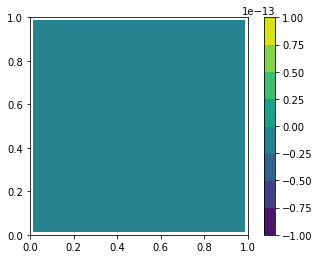

ifield = 1 /200


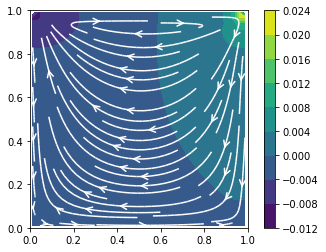

ifield = 2 /200


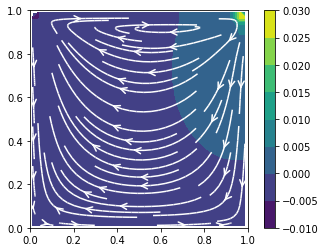

ifield = 3 /200


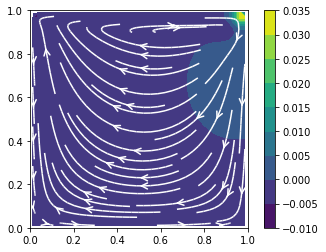

ifield = 4 /200


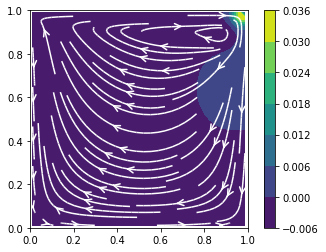

ifield = 5 /200


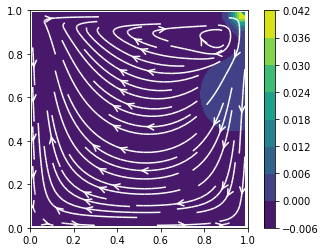

ifield = 6 /200


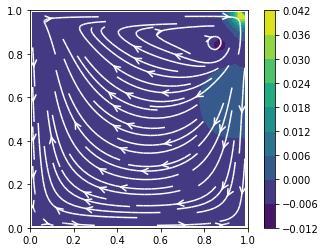

ifield = 7 /200


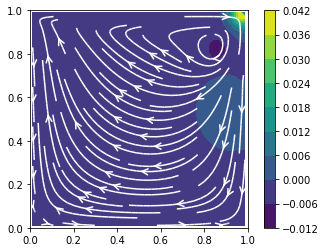

ifield = 8 /200


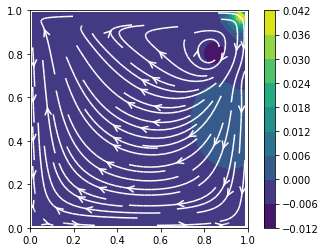

ifield = 9 /200


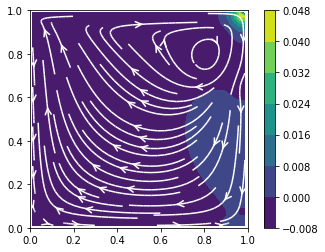

ifield = 10 /200


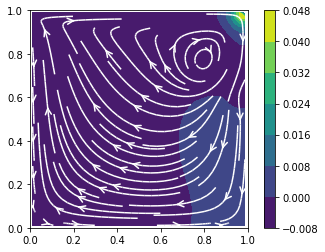

ifield = 11 /200


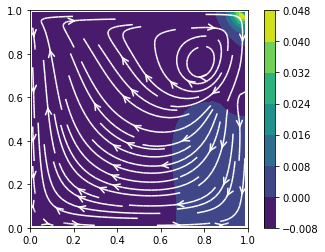

ifield = 12 /200


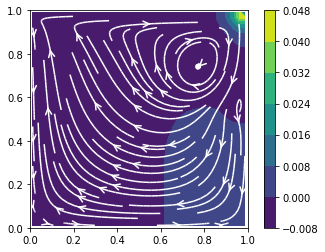

ifield = 13 /200


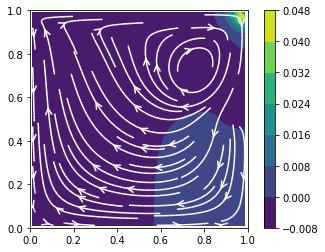

ifield = 14 /200


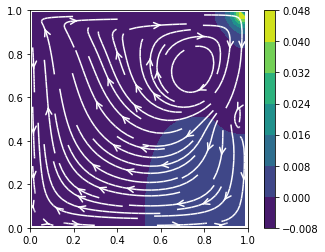

ifield = 15 /200


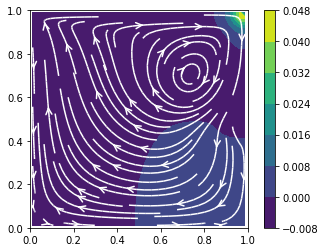

ifield = 16 /200


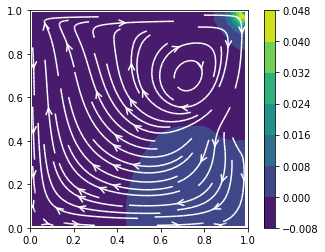

ifield = 17 /200


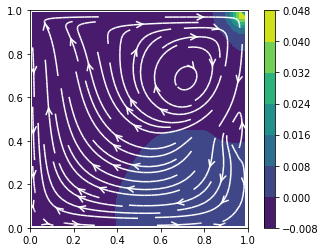

ifield = 18 /200


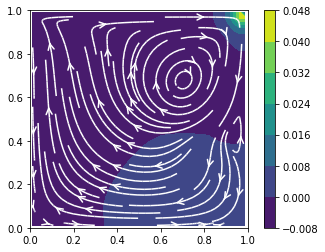

ifield = 19 /200


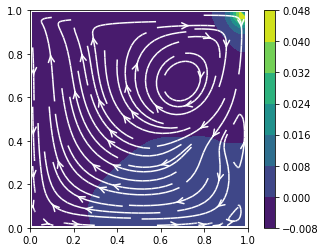

ifield = 20 /200


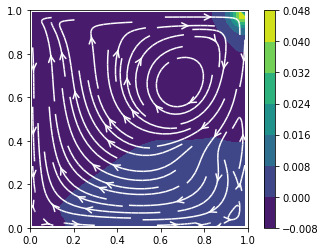

ifield = 21 /200


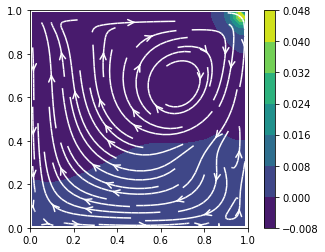

ifield = 22 /200


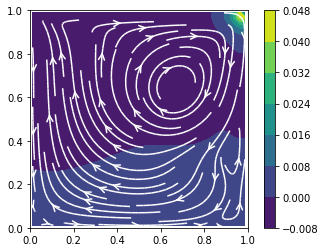

ifield = 23 /200


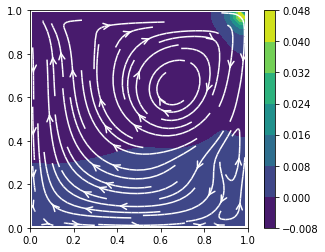

ifield = 24 /200


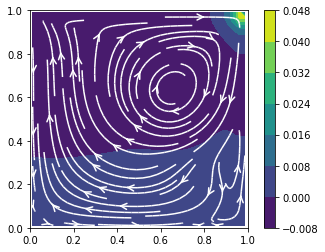

ifield = 25 /200


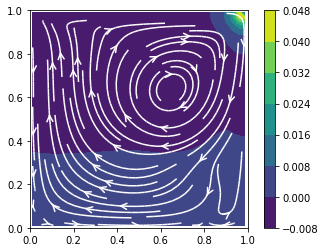

ifield = 26 /200


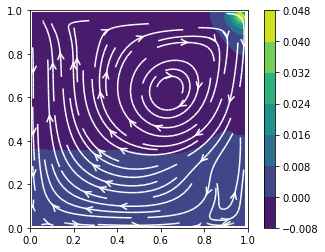

ifield = 27 /200


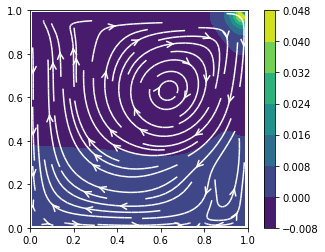

ifield = 28 /200


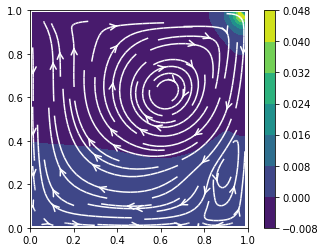

ifield = 29 /200


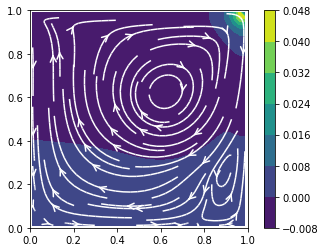

ifield = 30 /200


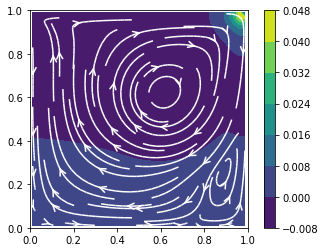

ifield = 31 /200


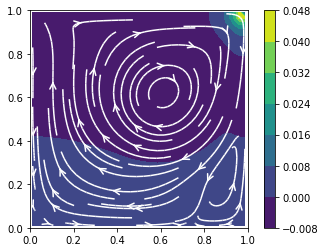

ifield = 32 /200


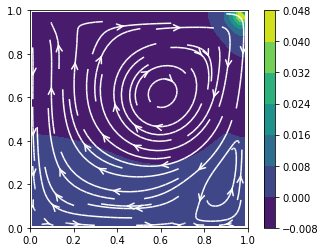

ifield = 33 /200


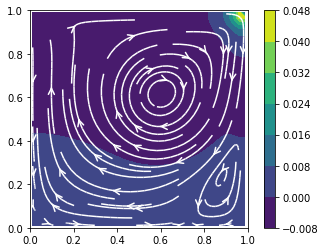

ifield = 34 /200


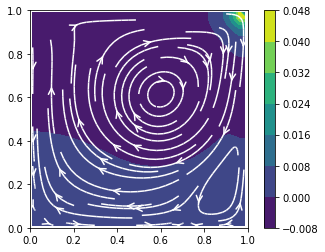

ifield = 35 /200


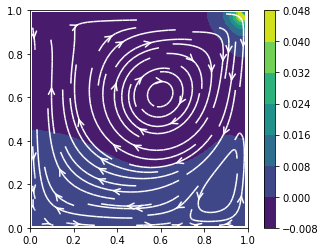

ifield = 36 /200


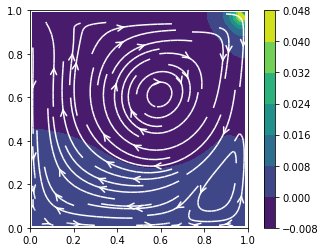

ifield = 37 /200


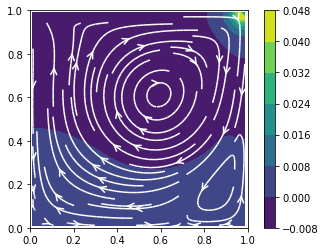

ifield = 38 /200


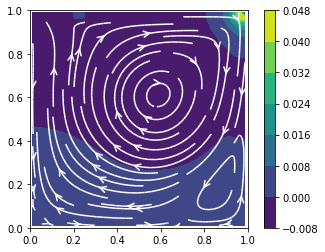

ifield = 39 /200


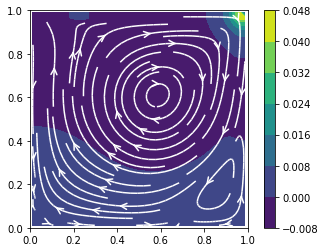

ifield = 40 /200


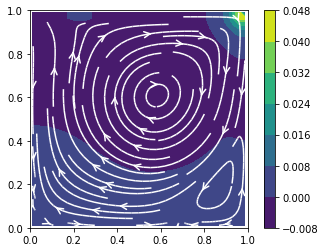

ifield = 41 /200


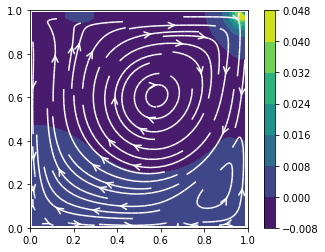

ifield = 42 /200


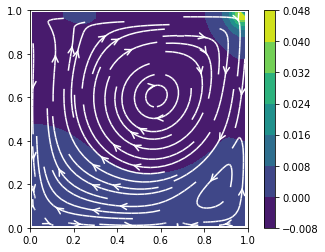

ifield = 43 /200


KeyboardInterrupt: 

In [1]:
# this read a fortran binary file (fields_****.fw) in ./cavity  
import matplotlib.pyplot as plt
import numpy as np
import time
# --------------------------------------------- #
icase=1
if icase==1:
    dir='../run/pool/'
    filename=dir+'fields_' 
    endian='l'; 
    recl=4; # 
    Lx=0.1; Ly=Lx; Nx=41; Ny=43
    Uwall=0.01; Kvis = 1.e-6; Dens = 1.e3;
    iff=0; ill=200; iskip=1 #0--200
    isave='png'
    
Re=Dens*Uwall*Lx/Kvis
print('processing icase='+'%d'%icase+' Re=%f'%Re)

dx=Lx/np.float(Nx+1)
dy=Ly/np.float(Ny+1)

x=np.array(np.zeros(Nx+2),dtype=np.float64)
xc=np.array(np.zeros(Nx+1),dtype=np.float64)
y=np.array(np.zeros(Ny+2),dtype=np.float64)
yc=np.array(np.zeros(Ny+1),dtype=np.float64)

uc=np.array(np.zeros((Nx+1,Ny+1),dtype=np.float64))
vc=np.array(np.zeros((Nx+1,Ny+1),dtype=np.float64))

# set uniform grid
x[0]=0.0
for i in range(1,Nx+2):
    x[i]=x[i-1]+dx; # raw grid
    xc[i-1]=0.5*(x[i-1]+x[i])/Lx # scaled grid centre
#end of for
y[0]=0.0
for i in range(1,Ny+2):
    y[i]=y[i-1]+dy; # raw grid 
    yc[i-1]=0.5*(y[i-1]+y[i])/Lx # scaled grid centre
#end of for
x2d, y2d = np.meshgrid(xc,yc) # *2 why ??

# Controlling the starting points of the streamlines

seed_points = np.array([x2d[::4,::4].reshape(121), y2d[::4,::4].reshape(121)])
#for i in range(x2d.size):
#    for j in range(y2d.size):
#        seed_points[i,j] = [x2d[i,j], y2d[i,j]]

# set file data type (Fortran binary)
# compiled by 
# $gfortran main.f90 # results data of little endian with 4byte record marker on MacOS
# use below 
# $gfortran -fconvert=big-endian main.f90 
# or 
# ----------------- #
# 4byte_recl+'u'+4byte_recl
# 4byte_recl+'v'+4byte_recl
# 4byte_recl+'p'+4byte_recl
# ----------------- #
#
#head = ("head",">i") # for big-endian binary (fujitsu fortran on Ito (Kyushu Univ.)??)
#head = ("head","<i")  # for little-endian binary (intel. gfortran??)
#tail = ("tail","<i")
#
if endian=="l":
    order='<'
elif endian=="b":
    order='>'
byte_head = order+'i'
byte_tail = order+'i'
byte_u = order+'%d'%((Nx+2)*(Ny+1))+'d'
byte_v = order+'%d'%((Nx+1)*(Ny+2))+'d'
byte_p = order+'%d'%((Nx+1)*(Ny+1))+'d'
fld_u = np.dtype([("head",byte_head), ("u",byte_u), ("tail", byte_tail)])
fld_v = np.dtype([("head",byte_head), ("v",byte_v), ("tail", byte_tail)])
fld_p = np.dtype([("head",byte_head), ("p",byte_p), ("tail", byte_tail)])


for ifield in range(iff,ill+1,iskip):
    print('ifield'+' = %d'%ifield+' /%d'%(ill) )

    time_start = time.time()

    file_fw=open(filename+'%04d'%ifield+'.fwd')
    # --- read u
    tmp = np.fromfile(file_fw, dtype=fld_u, count=1) # u
    if tmp[0]["head"]==((Nx+2)*(Ny+1)*8): 
        u=tmp[0]["u"].reshape(Ny+1,Nx+2)
    else:
        print('%d'%tmp[0]["head"]+' should be '+ '%d'%((Nx+2)*(Ny+1)*8))
        print('reading error: check the endian and the binary record length')
        exit()
    #endif
    # --- read v
    tmp = np.fromfile(file_fw, dtype=fld_v, count=1) # v
    v=tmp[0]["v"].reshape(Ny+2,Nx+1)
    # --- read p    
    tmp = np.fromfile(file_fw, dtype=fld_p, count=1) # p
    #p=tmp[0]["p"].reshape(Nx+1,Ny+1,order='F') # reading in fortran order with transposing
    p=tmp[0]["p"].reshape(Ny+1,Nx+1) 
    file_fw.close()
    time_read=time.time()
    #print('elapsed time to read: ',time_read-time_start)
    
    # interpolate
    uc=0.5*(u[:,:-1]+u[:,1:])/Uwall # interpolate at the cell centre with scaling
    vc=0.5*(v[:-1,:]+v[1:,:])/Uwall # interpolate at the cell centre with scaling

    time_interp=time.time()
    #print('elapsed time to interpolation: ',time_interp-time_read)

    # plot streamlines and pressure field
    fig_p, ax_p = plt.subplots()
    tcf=ax_p.contourf(xc,yc,p)
    fig_p.colorbar(tcf)
    #ax_p.contour(xc,yc,p, colors='k')
    
    #ax_p.streamplot(x2d,y2d,uc,vc,color='w',integration_direction='both',start_points=seed_points.T)
    ax_p.streamplot(x2d,y2d,uc,vc,color='w',integration_direction='both',arrowsize=1.5,arrowstyle="->",
                    minlength=0.2,maxlength=0.8,start_points=seed_points.T)
    
    #ax_p.streamplot(x2d,y2d,uc,vc,color='w',density=0.7,integration_direction='both',arrowsize=1.5,arrowstyle="->")
    #ax_p.streamplot(xc/Lx,yc/Lx,uc/Uwall,vc/Uwall,color='w',density=1,integration_direction='backward',arrowstyle="->")
    ax_p.set_aspect('equal')
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.show()
    #fig_p.savefig(filename+'%04d'%ifield+'.png')
    plt.close()
    
    # use make_moview_sample.sh for making a movies from the series of png files. 

    #print('elapsed time: ',time.time()-time_start)
        
#end of for ifield 

In [11]:
xc[::3].size

14